### Loads raw volumetric data in training format
* input volume -> NHWC
* output volume -> NHWC

In [1]:
import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import h5py
import helpers as H
from fastMRI.data import transforms as T

#Root directory of the project
ROOT_DIR = os.path.abspath(".")
TRAIN_DATASET_PATH = os.path.join(ROOT_DIR, "dataset")

# Dataset directories
LOW_DIR = "singlecoil_train_3D_images_48x/low/"
HIGH_DIR = "singlecoil_train_3D_images_48x/high/"

LOW_DIR_PATH = os.path.join(TRAIN_DATASET_PATH, LOW_DIR)
HIGH_DIR_PATH = os.path.join(TRAIN_DATASET_PATH, HIGH_DIR)
SAVE_DATA_PATH = os.path.join(TRAIN_DATASET_PATH, "singlecoil_train_3D_images_48x")
LOW_DIR_PATH, HIGH_DIR_PATH

('/home/hasib/MRI-reconstruction/dataset/singlecoil_train_3D_images_48x/low/',
 '/home/hasib/MRI-reconstruction/dataset/singlecoil_train_3D_images_48x/high/')

In [2]:
w, h = 128, 128
def rs_img(img):
    '''W and H is 128 now
    '''
    print(img.shape[-1])
    print(type(img.shape[-1]))
    flatten = [cv2.resize(img[:,:,i], (w, h), interpolation=cv2.INTER_CUBIC) for i in range(img.shape[-1])]
    img = np.array(np.dstack(flatten)) 
    return img


def change_depth(img):

    img_start = img[:,:,:4]
    
    mid = int(img.shape[-1]/2)
    img_middle = img[:,:,mid-10:mid+10]
    
    img_end = img[:,:,-4:]
    img = np.concatenate((img_start, img_middle, img_end), axis=2)
    return img


def show_slices(data, slice_nums, cmap=None):
    data = np.moveaxis(data, 2, 0)
    fig = plt.figure(figsize=(16, 16))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)        

#### Check number of contents

In [3]:
len(os.listdir(LOW_DIR_PATH)), len(os.listdir(HIGH_DIR_PATH))

(8, 8)

In [4]:
low_full_paths = ["{}/{}".format(LOW_DIR_PATH,l) for l in H.sort_paths(os.listdir(LOW_DIR_PATH))]
high_full_paths = ["{}/{}".format(HIGH_DIR_PATH,h) for h in H.sort_paths(os.listdir(HIGH_DIR_PATH))]

In [5]:
low_full_paths[:4]

['/home/hasib/MRI-reconstruction/dataset/singlecoil_train_3D_images_48x/low//1.npy',
 '/home/hasib/MRI-reconstruction/dataset/singlecoil_train_3D_images_48x/low//2.npy',
 '/home/hasib/MRI-reconstruction/dataset/singlecoil_train_3D_images_48x/low//3.npy',
 '/home/hasib/MRI-reconstruction/dataset/singlecoil_train_3D_images_48x/low//4.npy']

In [15]:
high_full_paths[:4]

['/home/hasib/MRI-reconstruction/dataset/singlecoil_train_3D_images_48x/high//1.npy',
 '/home/hasib/MRI-reconstruction/dataset/singlecoil_train_3D_images_48x/high//2.npy',
 '/home/hasib/MRI-reconstruction/dataset/singlecoil_train_3D_images_48x/high//3.npy',
 '/home/hasib/MRI-reconstruction/dataset/singlecoil_train_3D_images_48x/high//4.npy']

### Take a raw input volume

In [66]:
x = np.load("/home/hasib/MRI-reconstruction/dataset/singlecoil_train_3D_images_48x/high//1.npy")
x = np.moveaxis(x, 0, 2)
x.shape

(320, 320, 38)

In [67]:
a = x[:,:,20]
print(a.shape)
print(a[10:12, 20:24])

(320, 320)
[[1.01124897e-05 1.00766865e-05 9.92884725e-06 1.27582252e-05]
 [9.29892940e-06 1.15329321e-05 8.09639550e-06 1.14528148e-05]]


In [68]:
b = a.flatten()
print(max(b), min(b))

9.84871e-05 5.3640547e-06


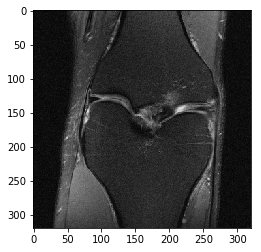

In [69]:
plt.imshow(a, cmap='gray')

Normalize

In [70]:
a, _, _ = T.normalize_instance(a)
a.shape

(320, 320)

In [71]:
print(a[10:12, 20:24])

[[-1.0471712  -1.0505506  -1.0645043  -0.79745513]
 [-1.1239587  -0.91310364 -1.2374591  -0.9206655 ]]


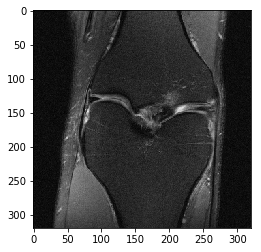

In [72]:
plt.imshow(a, cmap='gray')

In [73]:
a = a.flatten()
print(max(a), min(a))

7.294013 -1.4953495


#### LOW MRI VOLUMES

In [7]:
x_train = []
c=0

for l in low_full_paths[:500]:
    x = np.load("{}".format(l))
    x = np.moveaxis(x, 0, 2)
    x = change_depth(x)
    
    x_train.append(x)
    c+=1
    #print(c, "----", l, x.shape)
    
    
x_train = np.array(x_train)
x_train.shape

(500, 320, 320, 28)

#### HIGH MRI VOLUMES

In [8]:
y_train = []
c=0

for h in high_full_paths[:500]:
    y = np.load("{}".format(h))
    y = np.moveaxis(y, 0, 2)
    y = change_depth(y)
    
    y_train.append(y)
    c+=1
    #print(c, "----", h, y.shape)
    
    
y_train = np.array(y_train)
y_train.shape

(500, 320, 320, 28)

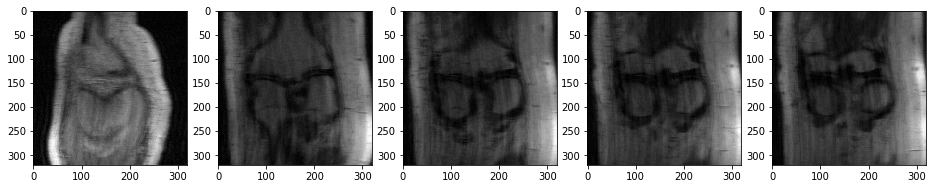

In [10]:
slice_num = [5, 16, 18, 19, 20]
n = 2
show_slices(x_train[n], slice_num, cmap='gray')

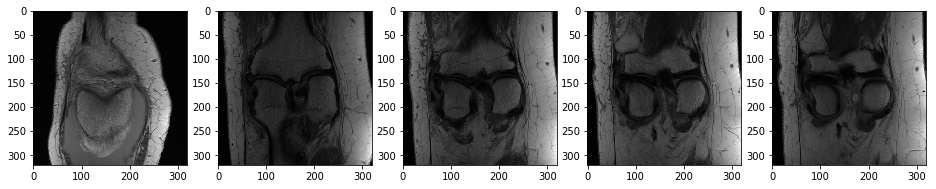

In [11]:
show_slices(y_train[n], slice_num, cmap='gray')

In [13]:
np.save("{}/x_train.npy".format(SAVE_DATA_PATH), x_train)
np.save("{}/y_train.npy".format(SAVE_DATA_PATH), y_train)

In [1]:
print("Done!")

Done!
